# This notebook describes analysis of data from Crazy Beliefs experiment 2

## Varying the location of one source boundary across participants

This study assesses how the weight given to one source varies as the distance between the source and the learner's initial boundary changes.

All participants first learn with labeled examples at 100 and 200 and are then assessed on a grid, without feedback, to determine the location of their initial implicit boundary $b_1$. All participants then complete 300 trials (all stimuli appear once in permuted order) and, following their decision, view labels provided by two sources. For all participants one of the sources uses a boundary 15 units from the midpoint (the FIXED source $b_f$ at either 135 or 165). The other VARYING source boundary $b_v$ is sampled at random for each subject with uniform probability from the stimulus range opposite the FIXED source (ie, $b_v \in [0,149]$ if $b_f = 165$ or $b_v \in [151,300]$ if $b_f = 135$). After these trials we again assess behavior on a grid to estimate the learner's final implicit boundary $b_2$, then ask learners to rate the two sources for their knowledge, trustworthiness, accuracy, and attractiveness. 

From the two boundary estimates we compute the shift $s = b_2 - b_1$. We model the shift as a proportional weighted sum of the difference, for each source, between the source boundary and the learner's initial boundary:

$$s = p_v d_v + (1 - p_v) d_f$$

...where $p_v$ is the proportional weight given to the varying source, $d_v$ is the difference between the varying source boundary and the learner's initial boundary $(b_v - b_1)$, and $d_f$ is the difference between the fixed source boundary and the learner's initial boundary $(b_f - b_1)$. This allows us to estimate the proportional weight given to the varying source as follows:

$$p_v = \frac{s - d_f}{d_v - d_f}$$

Since these estimates are noisy they occasionally exceed the limits of 1.0 and 0.0, so we then clip such estimates at 1.0 or 0.0. The central question concerns whether/how the proportional weight given to the varying source in each subject depends on the distance between the far source boundary and the learner's initial boundary. That is, what is the function by which $p_v ~ d_v$. Finally, we also consider whether/how the explicit ratings of the two sources relate to the estimate of the weight they are given. 

The rest of the notebook reads in the data and describes the analysis assessing this question. Note that the raw data have been pre-processed to compute the relevant boundary and shift information.


# Functions

Useful functions defined or read in here.

In [1]:
get.pwt <- function(x, s, i=0, p=1){
    #Function that returns the proportional weight of a source given the
    #source's distance from the learner's boundary
    #and parameters for the offset and slope
    #x = vector of source distances for which weights should be returned
    #s = constant determining slope of decay
    #i = "intercept" or offset term that shifts curve left/right
    #p = experimental parameter, don't use
    #o = output vector of weights
    ###########
    
    x <- x-i
    o <- 1 - (x/(x + s))
    o <- o^p
    o[o>1] <- 1.0
    o
}


In [2]:
zscore <- function(v, sigd = 2){
    #Zscores the data in a vector after removing NA cells
    #v = numeric vector of data
    #output is rounded to sigd significant digits
    round((v - mean(v, na.rm=T))/sqrt(var(v, na.rm=T)),sigd)
    }


In [3]:
plot.pfit <- function(noo, s=25, o=4.5){
    #Plots weight estimate against source distance along with a curve generated
    #by get.pwt, using the parameters specified by s and o
    #inc: subjects to include; removes items flagged as outliers by default
    #s = slope of the curve
    #o = offset of the curve
    ###########
    dmat.noo <- noo
    
    #Scatterplot
    plot(dmat.noo$AlVar, dmat.noo$VarPClip,  pch=16, xlab = "Distance of varying  source", 
        ylab = "Weight of varying source",  xlim = c(0,165), ylim = c(0,1))
    
    #Add line indicating model prediction
    lines(c(0:165), get.pwt(c(0:165), s, o),  col=2, lwd=2)

    #Text indicating the model
    modtext <- paste("pWt_var = 1 - (Dvar - ", o, ")/(Dvar - ", o, " + ", s, ")", sep="")
    text(70,1,labels = modtext, col=2, adj = 0)

    #Text indicating the model fit
    sse <- sum((dmat.noo$VarPClip - get.pwt(dmat.noo$AlVar,  s, o))^2)
    toterr <- sum((dmat.noo$VarPClip - mean(dmat.noo$VarPClip))^2)
    fittext <- paste("r^2 = ", round(1-(sse/toterr),2),  sep="")
    text(70,.95,labels = fittext, col=2, adj = 0)
}


## Data

Threshold for outlier analysis

In [5]:
zthresh <- 2.0

In [6]:
alldat <- read.csv("all_data.csv", header = T)
head(alldat)

Oord,C_R,L_R,Sno,SID,FixSrcBnd,VarSrcBnd,B1,B2,DirShift,...,TrustFixed,AccVary,AccFixed,AttVary,AttFixed,Kdiff,Tdiff,AccDiff,AttDiff,MnDiff
1,C,LB,1,CLB1,165,43,154,153,0,...,76,68,81,56,58,17,8,13,2,12.7
2,C,LB,2,CLB2,165,91,154,171,17,...,50,50,50,1,1,0,0,0,0,0.0
3,C,LB,3,CLB3,165,49,169,136,-33,...,52,65,53,58,36,-32,-23,-12,-22,-22.3
4,C,LB,4,CLB4,165,114,207,154,-53,...,55,53,50,50,50,11,-3,-3,0,1.7
5,C,LB,5,CLB5,165,57,146,146,0,...,79,55,73,72,53,17,18,18,-19,17.7
6,C,LB,6,CLB6,165,92,154,154,0,...,96,96,96,64,15,15,18,0,-49,11.0


The alldat.csv file contains all the relevant estimates for each of 64 participants. Fields are as follows:

*Subjects and conditions*

Oord: Original ordering
C_R: Is the spiky end of the spectrum labeled Raw or Cooked?
L_R: Is the varying source toward the left (spiky end) or right (smooth end) of the spectrum?
Sno: Subject number within condition
SID: Unique subject ID
FixSrcBnd: Location of the fixed source boundary
VarSrcBnd: Location of the varying source boundary

*Data*

B1: Initial implicit boundary
B2: Final implicit boundary

DirShift: Final - initial implicit boundary, not aligned for which side the varying side is on
DirFix: Fixed - initial boundary, not aligned
DirVar: Varying - initial boundary, not aligned

**Note:** These are the raw differences, not taking into account which end of the axis (spiky/smooth) was labeled with the fixed source and which with the varying source. So for hald the subjects, the difference DirVar (for instance) will be negative and for half it will be positive. We want to do the analysis on data that have been \emph{aligned} so that a negative number indicates a distance or movement toward the pole nearest the \emph{varying} source---hence the next three fields, which simply flip these numbers around the origin for cases where the round (positive) end of the spectrum was labeled with the varying source.

AlShift: Amount of shift aligned so that negative numbers indicate a shift toward the varying source boundary
AlFix: Aligned distance from initial to fixed boundary ($d_f$)
AlVar: Aligned distance from initial to varying boundary  ($d_v$)
VarP: Proportional weight given to varying source ($p_v$)
VarPClip: Values of VArP > 1 replaced with 1, < 0 replaced with 0.
Outlier: Indicates an outlier, defined as cases where the amount of shift is greater than 2.5 standard deviations from the mean over subjects.

*Face data fields*

Kvary, Kfixed: Knowledge rating for the varying and the fixed source.
TrustVary, TrustFixed: Trust rating for the varying and fixed source.
AccVary, AccFixed: Accuracy estimate for the varing and fixed source.
AttVary, AttFixed: Attractiveness estimate for the varying and fixed source.

Kdiff: Fixed rating - Varying rating for knowledge, positive numbers favor fixed source
Tdiff: Fixed rating - Varying rating for trust 
AccDiff: Fixed rating - Varying rating for accuracy
AttDiff: Fixed rating - Varying rating for attractiveness

**Note:** Odd subject numbers had Adam as the fixed source and Mark as the varying source, even numbers received the reverse pairing.



# Outlier analysis

As in Study 1, we first remove any subjects with impossible boundary values in test 1 or test 2 (likely reflecting random responding). Across all subjects, we compute Zscores for the initial boundary and remove any with v unusual starting boundaries (Z more than 2.5 standard deviations from mean). Finally, we compute aligned shift scores from the remaining and remove any subjects with very unusual shift scores (more than 2.5 standard deviations from the mean).

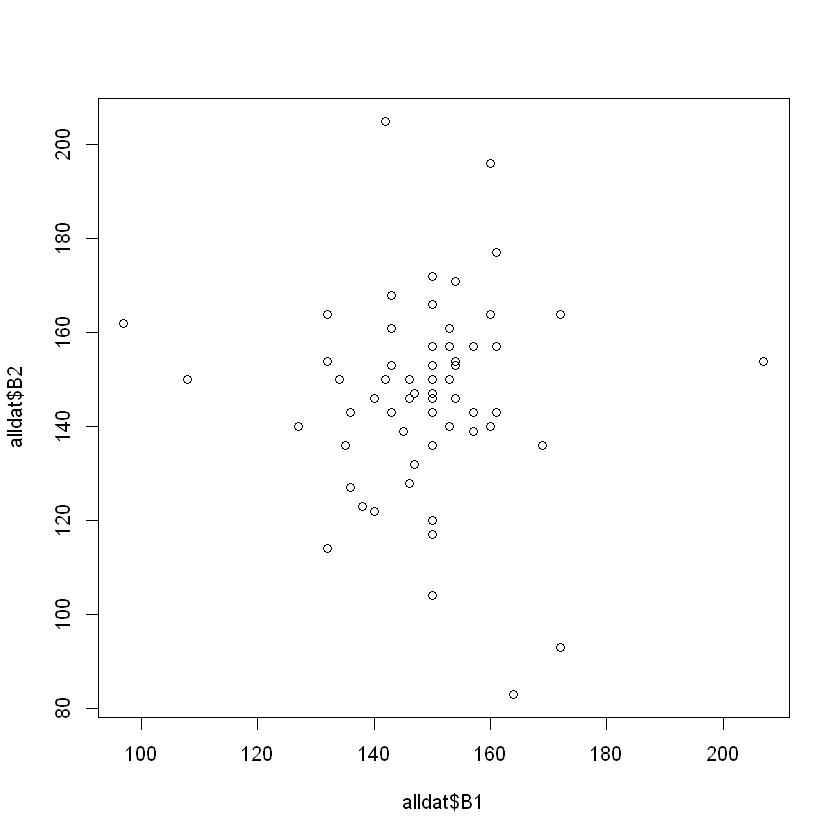

In [7]:
plot(alldat$B1, alldat$B2)

There are no impossible values in either test, so now check the initial boundary estimate for outliers

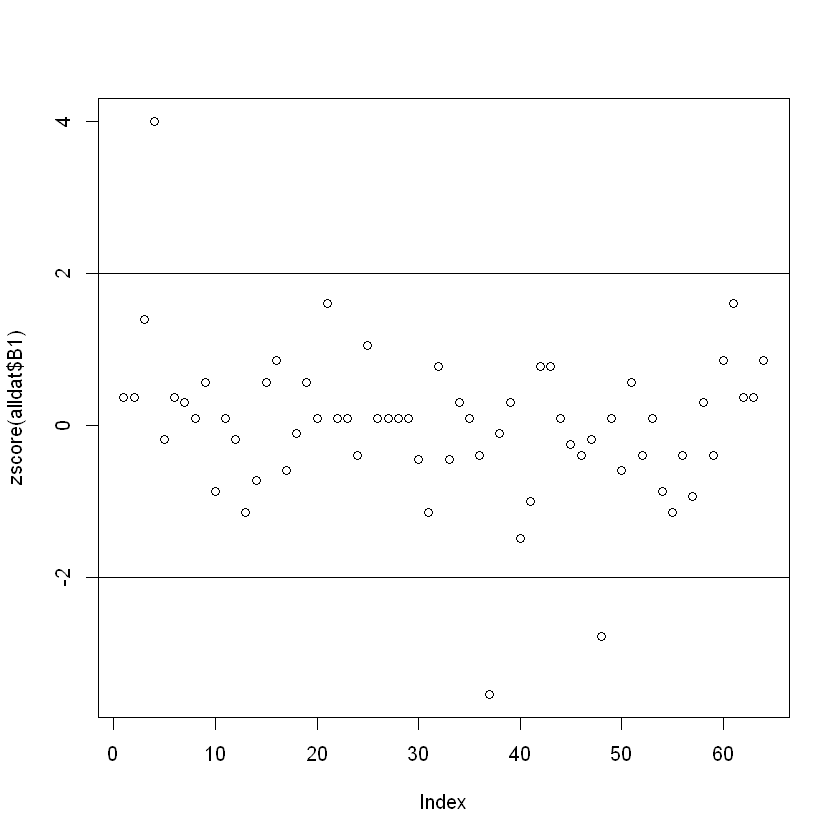

In [8]:
plot(zscore(alldat$B1)); abline(h=c(zthresh,-zthresh))

Add outliers to exclude list and remove from "no outlier" object

In [9]:
sjex <- as.character(alldat$SID[abs(zscore(alldat$B1)) > zthresh]) #Add outlier SIDs to exlcude list
noo <- alldat[is.na(match(alldat$SID, sjex)),] #Copy all other subjects to noo object
dim(alldat) #Check original size of dataset
dim(noo)    #Check reduced data to make sure 2 were removed

[1] 64 32

[1] 61 32

Now check the aligned boundary shift data for extreme values 

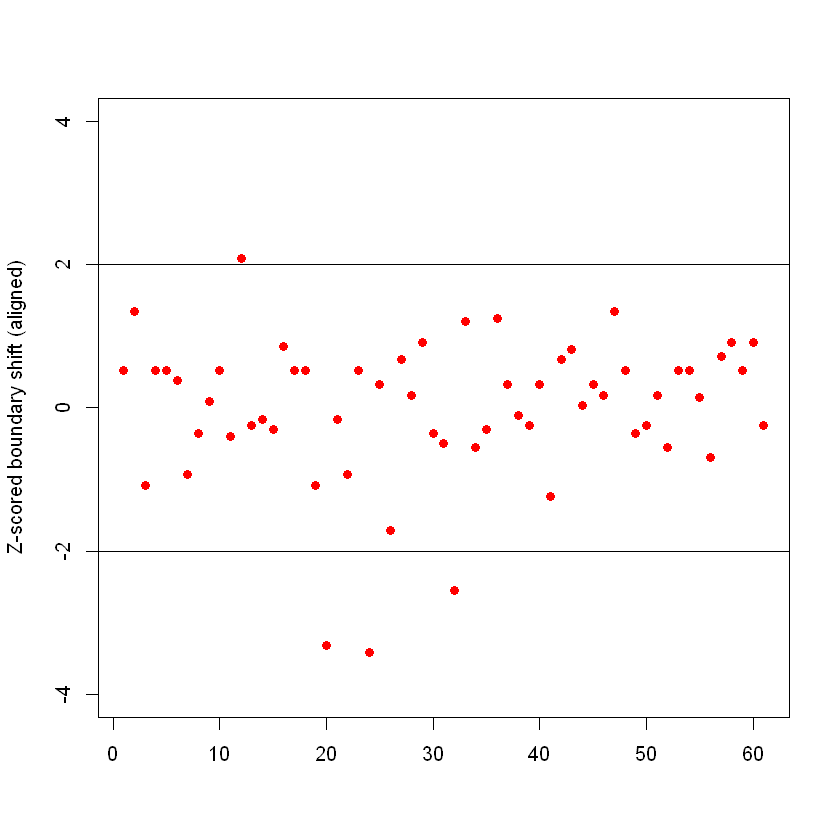

In [10]:
plot(zscore(noo$AlShift), ylim = c(-4,4), xlab="", ylab="Z-scored boundary shift (aligned)",
     pch=16, col = 2)
abline(h=c(-zthresh, zthresh))

Remove any outliers.

In [11]:
sjex <- c(sjex, as.character(noo$SID[abs(zscore(noo$AlShift))>zthresh]))
sjex <- unique(sjex)
noo <- alldat[is.na(match(alldat$SID, sjex)),]
dim(noo)

[1] 57 32

## Analysis

Now double-check that the data are normally distributed and that the location of the initial boundary makes sense:


	Shapiro-Wilk normality test

data:  noo$B1
W = 0.98062, p-value = 0.4906


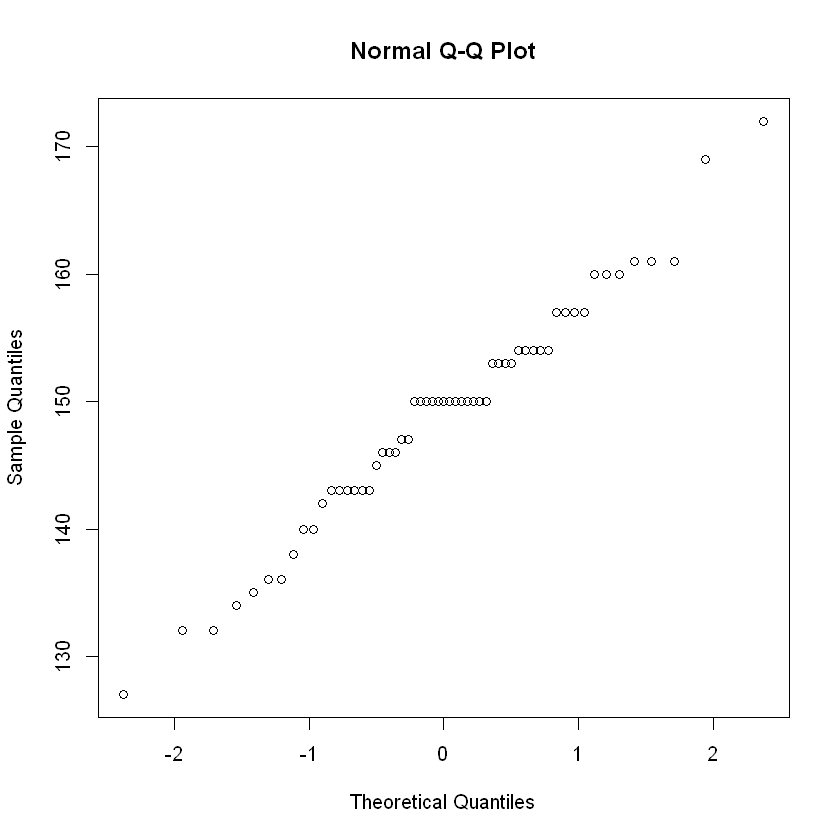

In [12]:
qqnorm(noo$B1)
shapiro.test(noo$B1)

The initial boundary location is normally distributed.

### Initial boundary location and mean shift

First assess confidence limits on location of initial boundary:

In [13]:
t.test(noo$B1)


	One Sample t-test

data:  noo$B1
t = 124.06, df = 56, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 146.5596 151.3702
sample estimates:
mean of x 
 148.9649 


Next look at the mean shift across all subjects, ignoring the location of the varying source. We look at the aligned shift, so that positive numbers indicate a shift toward the "fixed-source" side of the spectrum and a negative number indicates a shift toward the "varying-source" side for all subjects:

In [14]:
t.test(noo$AlShift)


	One Sample t-test

data:  noo$AlShift
t = -4.44, df = 56, p-value = 4.279e-05
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -11.889511  -4.496454
sample estimates:
mean of x 
-8.192982 


The boundary shifts reliably away from the fixed source and toward the varying source.

### Estimating weight given to varying source.


Now let's look at how the estimated weight on the varying source varies with the distance of the varying source. The estimated weight for each participant was computed using the formulas and get.pwt function defined at the beginning of the notebook. We then sought to predict this weight as a function of the distance from the participant's initial boundary and the variable source. We looked at a linear model, a logistic model, and the _heuristic evidence-weighting model_ described in the paper.

In [15]:
#First try a linear model
m1 <- lm(VarPClip ~ AlVar, data = noo)
summary(m1)


Call:
lm(formula = VarPClip ~ AlVar, data = noo)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44563 -0.12646 -0.01942  0.13555  0.42993 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.6339217  0.0603631  10.502 9.38e-15 ***
AlVar       -0.0046746  0.0008291  -5.638 6.13e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1869 on 55 degrees of freedom
Multiple R-squared:  0.3663,	Adjusted R-squared:  0.3548 
F-statistic: 31.79 on 1 and 55 DF,  p-value: 6.133e-07


In [16]:
#Next try a logistic model
m2 <- glm(VarPClip ~ AlVar, data = noo, family="binomial")
summary(m2)

Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"


Call:
glm(formula = VarPClip ~ AlVar, family = "binomial", data = noo)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.04623  -0.26236  -0.08551   0.29883   0.92150  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.75425    0.71689   1.052   0.2927  
AlVar       -0.02379    0.01102  -2.160   0.0308 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 15.0969  on 56  degrees of freedom
Residual deviance:  9.7281  on 55  degrees of freedom
AIC: 58.878

Number of Fisher Scoring iterations: 4


In [17]:
#Estimate model r-squared:
cor(predict(m2, noo), noo$VarPClip)^2

[1] 0.3662824

**Note:** Warning occurs because the dependent variable is not an integer, but the best fitting line will be the same if the dependent variable is a proportion as it is here.

How do we find good parameters for the HEW model? Probably we could do this analytically, but I conducted a grid search---I chose a bunch of possible values for the intercept and slope parameters of the curve, and for each, I measured the sum-squared error with the data, then looked for the values that minimized that error, as follows:

In [18]:
igrid <- c(0:30)/2 #grid of intercept parameters from 0-15 in steps of 0.5
sgrid <- c(0:30) #grid of slope parameters from 0-30 in steps of 1
mfit <- matrix(0, length(igrid), length(sgrid)) #matrix to contain the fit (sse) estimates for each parameter pair

tmp <- noo #Copy no-outlier object to tmp object

for(i in c(1:length(igrid))){#iterate over intercept grid
    for(s in c(1:length(sgrid))){ #iterate over slope grid
        tmp1 <- get.pwt(tmp$AlVar, i=igrid[i], s=sgrid[s]) #Get model predictions at this grid point
        mfit[i,s] <- sum((tmp1 - tmp$VarPClip)^2) #Compute model SSE at this grid point
        }
    }
mfit[is.na(mfit)] <- max(mfit, na.rm=T) #Replace any NA values with the grid maximum
mfit[mfit==Inf] <- max(mfit[mfit!=Inf]) #Replace any infinite values with real grid maximum

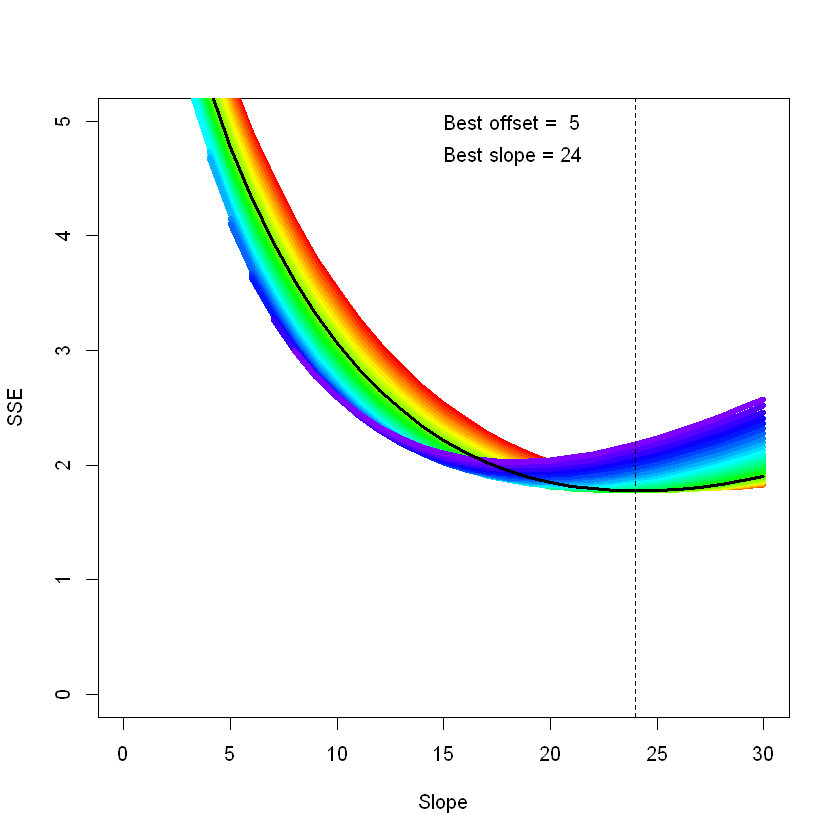

In [19]:
#mfit now contains model error at each grid point, let's plot
plot(0,0,type = "n", xlab = "Slope", ylab="SSE", xlim = c(0,30), ylim = c(0,5)) #Empty plot

lowesto <- 0 #initialize lowest offset variable

for(i1 in c(1:31)){ #For each offset
    if(min(mfit[i1,], na.rm=T) == min(mfit, na.rm=T)) lowesto <- i1 #set lowesto to i1 if it has the lowest error
    ppts <- c(1:31)[mfit[i1,] < 6]  #Only include points where line is lwaa than ylim max to make plot prettier
    lines(sgrid[ppts], mfit[i1,ppts], col=hsv((i1-1)/40,1,1), lwd = 5) #Plot a line showing curve at this offset over slopes
    }
lines(sgrid, mfit[lowesto,], lwd = 3, col = 1) #Plot the offset curve that produces lower error
text(15,5, labels=paste("Best offset = ", igrid[lowesto]), adj=0) #Print this offset value
lowests <- sgrid[mfit[lowesto,]==min(mfit, na.rm=T)] #Find slope that produces lowest error at this offset
abline(v=lowests, lty=2) #Plot dotted line showing that slope
text(15,4.7, labels=paste("Best slope =", lowests), adj=0)
bests <- lowests
besto <- igrid[lowesto]

The Figure shows the sum squared error between a curve (each defined by one offset/slope parameter pair) and the data. The curves are each plotted in a different rainbow color ranging from red to purple as the offset parameter increases. The black curve shows the offset that produces the lowest error overall, the the dotted line shows the slope at which that error occurs. The best pair of parameters are shown at the top.

We can compute the proportion of variance accounted for by this curve ($r^2$) by taking the sum-squared error for the curve and dividing it by the total sum squared error (ie sum of squared differences from the mean):

In [20]:
p <- get.pwt(noo$AlVar, s=bests, i=besto)  #predicted p for variable source
sse <- sum((p - noo$VarPClip)^2)      #sum squared error from the regression line
toterr <- sum((noo$VarPClip - mean(noo$VarPClip))^2)   #Sum squared error from the mean
1 - sse/toterr    #Proportion of total error explained by the regression line

[1] 0.4132933

So HEW model accounts for more variance than either logistic or linear model.

Here we can look at plot of residuals:

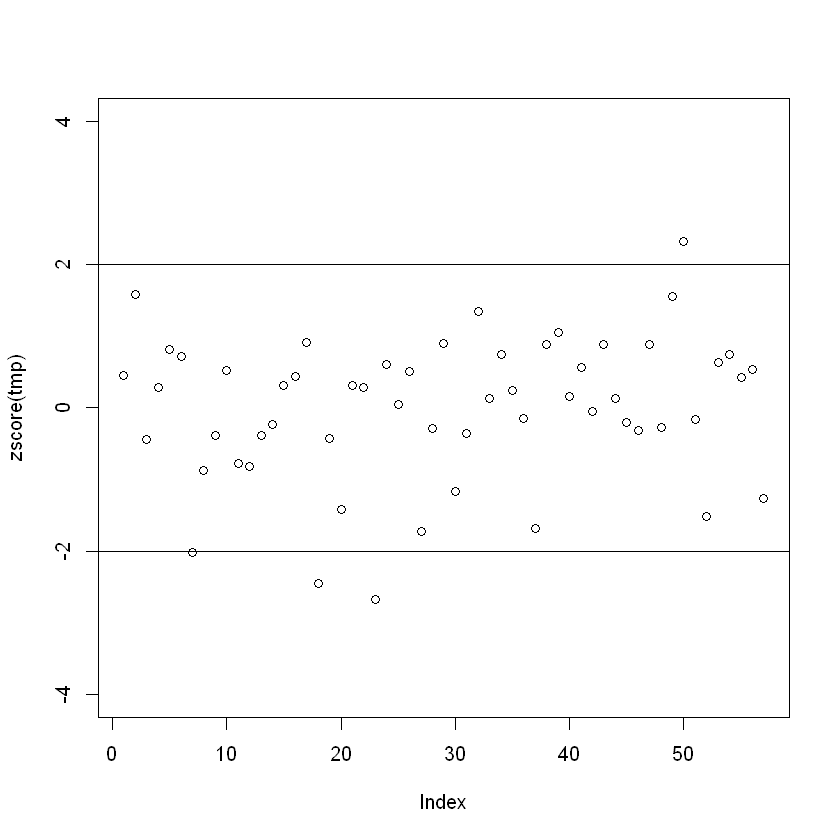

In [21]:
tmp <- get.pwt(noo$AlVar, s=24, i=5) - noo$VarPClip #HEW model residuals
plot(zscore(tmp), ylim = c(-4,4)); 
abline(h=c(-zthresh, zthresh))


	Shapiro-Wilk normality test

data:  tmp
W = 0.96178, p-value = 0.06903


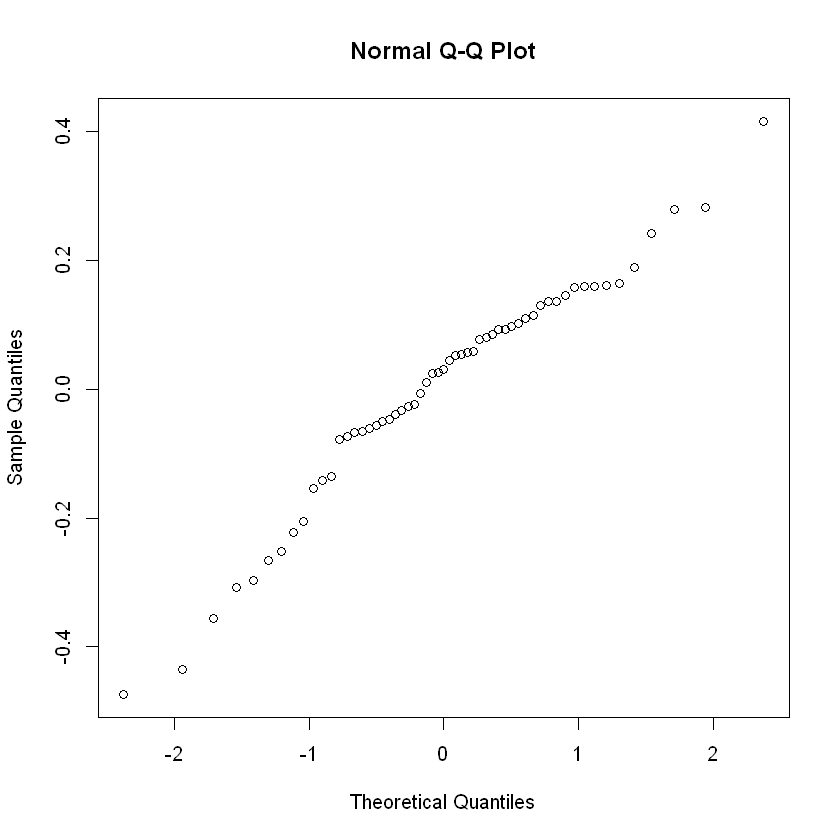

In [22]:
qqnorm(tmp)
shapiro.test(tmp)

Residuals look slightly leptokurtic but still not reliably different from zero.

The following block of code removes items with residuals outside the outlier cutoff for a less conservative view of model fit. We have left it commented out in final analysis.

In [23]:
#sjex <- c(sjex, as.character(noo$SID[abs(zscore(tmp)) > zthresh])) #Add residual outliers to exclude list
#sjex <- unique(sjex) #Remove any accidental repeats from exclude list
#noo <- noo[is.na(match(noo$SID, sjex)), ]  #Remove from noo object
#dim(noo)

Now plot the estimated weight for the distal source against the amount of boundary shift, and show fitted lines for the three models. Optionally also show the linear (green) and logistic (blue) regression lines, and the HEW curve that would be observed if participant boundaries did not shift (red dotted).

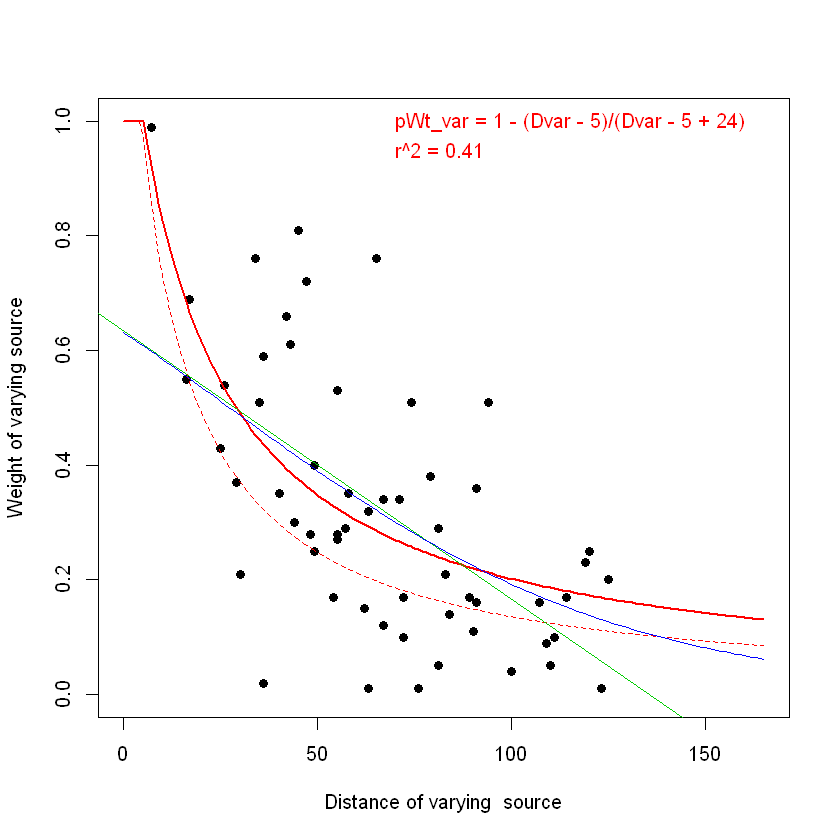

In [24]:
plot.pfit(noo, s = bests, o = besto)   #Plot with HEW curve
lines(0:165, get.pwt(0:165, s=15, i=4.5), lty = 2, col = 2) #Add HEW curve that predicts 0 change
abline(m1$coefficients, col = 3)  #Line from linear model
lines(0:165, 1/(1 + exp(-1 * (0.54 - 0.019743 * c(0:165)))), col = 4)    #Add curve from sigmoid model


**The plot shows,** for each subject, the distance between the initial boundary and far source (X axis) and the estimate of the proportional weight given to the far source (Y axis). The green line shows the linear fit; the blue line shows the logistic fit. Neither is as good as the HEW function shown by the solid red line. The dotted red line indicates what the estimated weight would be when $s=15$, the value that would produce no boundary change on average. The curve estimated from the data always gives more weight to the varying source.


## Additional analyses

Below are some additional analyses not discussed in the paper.

### Source ratings

Now let's look at the relationship between performance on the categorization task and ratings of the two sources for knowledge, trust, accuracy, and attractiveness. For each attribute we will plot the *fixed-source advantage*, that is, the rating of the fixed source minus the rating of the varying source. When this is positive, people rated the fixed source more highly; when negative, they rated the varying source more highly. First let's consider how this fixed-source advantage varies with the weight given to the varying source.

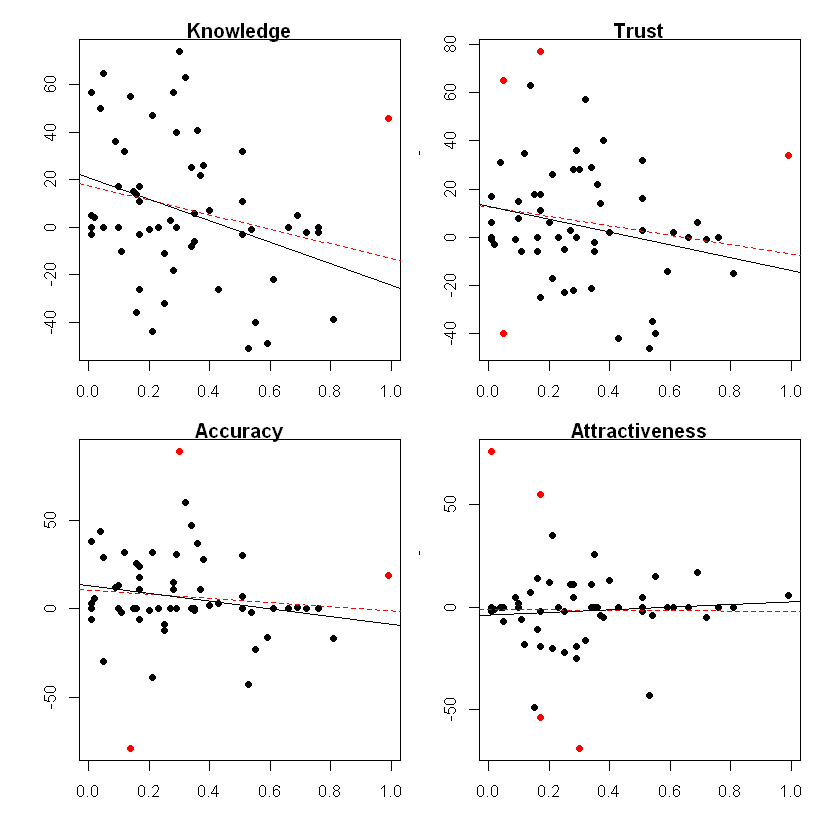

In [50]:
par(mfrow = c(2,2), mar = c(3,3,1,1), oma = c(1,1,1,1))
tmp <- noo #Copy no outlier object to tmp object

#For knowledge
m <- lm(Kdiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
plot(tmp$VarPClip, tmp$Kdiff, pch = 16, xlab="Varying source weight", ylab="Fixed advantage",
     col = 2 - as.numeric(inc)) #Plot with high-leverage points in red
title("Knowledge")
abline(lm(Kdiff ~ VarPClip, data = tmp)$coefficients, col=2, lty=2) #Line including high-leverage
abline(lm(Kdiff ~ VarPClip, data = tmp[inc==1,])$coefficients) #Line excluding high-leverage

m <- lm(Tdiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
plot(tmp$VarPClip, tmp$Tdiff, pch = 16, xlab="Varying source weight", ylab="Fixed advantage",
     col = 2 - as.numeric(inc)) #Plot with high-leverage points in red
abline(lm(Tdiff ~ VarPClip, data = tmp)$coefficients, col=2, lty = 2)
abline(lm(Tdiff ~ VarPClip, data = tmp[inc==1,])$coefficients)
title("Trust")

m <- lm(AccDiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
plot(tmp$VarPClip, tmp$AccDiff, pch = 16, xlab="Varying source weight", ylab="Fixed advantage",
     col = 2 - as.numeric(inc)) #Plot with high-leverage points in red
abline(lm(AccDiff ~ VarPClip, data = tmp)$coefficients, col=2, lty=2) #Line including high-leverage
abline(lm(AccDiff ~ VarPClip, data = tmp[inc==1,])$coefficients)
title("Accuracy")

m <- lm(AttDiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
plot(tmp$VarPClip, tmp$AttDiff, pch = 16, xlab="Varying source weight", ylab="Fixed advantage",
    col = 2 - as.numeric(inc)) #Plot with high-leverage points in red 
abline(lm(AttDiff ~ VarPClip, data = tmp)$coefficients, col=2, lty=2) #Line including high-leverage
abline(lm(AttDiff ~ VarPClip, data = tmp[inc==1,])$coefficients)
title("Attractiveness")


Red indicates high-leverage points, ie, points whose inclusion significantly affects the slope of the regression line. The solid black line shows the best fit excluding high-leverage points; red indicates best fit including high-leverage points. The correlation is significant for Knowledge and Trust when the high-leverage points are excluded

In [74]:
tmp <- noo #Remove outliers from data

#For knowledge
m <- lm(Kdiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
summary(lm(Kdiff ~ VarPClip, data = tmp[inc==1,]))


Call:
lm(formula = Kdiff ~ VarPClip, data = tmp[inc == 1, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-52.870 -14.589   0.493  16.248  67.838 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)    15.19       6.78   2.241   0.0294 *
VarPClip      -30.10      18.37  -1.639   0.1073  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 27.62 on 52 degrees of freedom
Multiple R-squared:  0.0491,	Adjusted R-squared:  0.03081 
F-statistic: 2.685 on 1 and 52 DF,  p-value: 0.1073


In [75]:
tmp <- noo #Remove outliers from data

#For knowledge
m <- lm(Tdiff ~ VarPClip, data = tmp) #Fit linear model
inc <- (cooks.distance(m) < 4/dim(tmp)[1]) #Exclude high-leverage points
summary(lm(Tdiff ~ VarPClip, data = tmp[inc==1,]))


Call:
lm(formula = Tdiff ~ VarPClip, data = tmp[inc == 1, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-44.869 -12.403  -1.458  11.295  53.981 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   12.663      5.597   2.263    0.028 *
VarPClip     -26.027     14.422  -1.805    0.077 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.4 on 51 degrees of freedom
Multiple R-squared:  0.06003,	Adjusted R-squared:  0.0416 
F-statistic: 3.257 on 1 and 51 DF,  p-value: 0.07703


The regression is not significant for Accuracy or Attractiveness